In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM/inferencing")

In [2]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score, auc
from tqdm import tqdm
import pandas as pd
import json, torch

from cover_alpaca2jsonl import format_example

In [3]:
model_path = "THUDM/chatglm2-6b"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device = "cuda")
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device_map = "auto")
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, device_map = "auto")
model = torch.compile(model)
model = model.eval()

[2023-07-26 22:36:55,117] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so
CUDA SETUP: CUDA runtime path found: /xfs/home/tensor_zy/anaconda3/envs/isaacgym/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

### Load Dataset

In [4]:
from datasets import load_dataset
import datasets

dataset = load_dataset("winogrande",'winogrande_xl')
dataset = dataset['validation']
dataset

Found cached dataset winogrande (/xfs/home/tensor_zy/.cache/huggingface/datasets/winogrande/winogrande_xl/1.1.0/a826c3d3506aefe0e9e9390dcb53271070536586bab95849876b2c1743df56e2)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['sentence', 'option1', 'option2', 'answer'],
    num_rows: 1267
})

In [5]:
dataset = dataset.to_pandas()
dataset.head(2)

,sentence,option1,option2,answer
0,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,2
1,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,1


In [6]:
dataset['instruction'] = 'Please choose the best answer from the two options.'
dataset['input'] = dataset.apply(lambda x:x['sentence'] + " {" + x['option1']+"/"+x["option2"]+"}.",axis = 1)
dataset['output'] = dataset.apply(lambda x:x['option1'] if x['answer'] == 1 else x['option2'], axis = 1)
dataset.head(2)

,sentence,option1,option2,answer,instruction,input,output
0,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,2,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria
1,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,1,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria


In [7]:
dataset[["context","target"]] = dataset.apply(format_example, axis = 1, result_type="expand")
dataset.head(2)

,sentence,option1,option2,answer,instruction,input,output,context,target
0,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,2,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria,Instruction: Please choose the best answer fro...,Maria
1,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,1,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria,Instruction: Please choose the best answer fro...,Maria


In [8]:
context = dataset['context'].tolist()
len(context)

1267

In [9]:
batch_size = 64

total_steps = dataset.shape[0]//batch_size
total_steps

19

In [10]:
res_list = []
res_sentences_list = []
out_text_list = []

for i in tqdm(range(total_steps+1)):
    tmp_context = context[i* batch_size:(i+1)* batch_size]
    tokens = tokenizer(tmp_context, return_tensors='pt', padding=True, max_length=512)
    for k in tokens.keys():
        tokens[k] = tokens[k].cuda()
    
    res = model.generate(**tokens, max_length=512)
    res_sentences = [tokenizer.decode(i) for i in res]
    out_text = [o.split("Answer: ")[1] for o in res_sentences]
    res_list += res
    res_sentences_list += res_sentences
    out_text_list += out_text
    torch.cuda.empty_cache()

100%|██████████| 20/20 [08:48<00:00, 26.42s/it]


In [11]:
res_list = [i.cpu() for i in res_list]

In [12]:
dataset["res"] = res_list
dataset["res_sentences"] = res_sentences_list
dataset["out_text"] = out_text_list

In [13]:
out_text_list[:10]

['1. Sarah',
 '1. Sarah',
 '1.\n\nOutput: blankets',
 '\n\n Output: eggplant',
 '1. Jeffrey',
 "1. Sarah is a responsible cat owner.\n\nExplanation: The correct answer is 1. Sarah is a responsible cat owner. The sentence states that Sarah takes her cat to see Maria, which implies that Sarah is the cat's owner.",
 '1.',
 '1.\n\n Output: house',
 '1.',
 '1']

In [14]:
dataset.answer.unique()

array(['2', '1'], dtype=object)

In [18]:
def change_target(x):
    x = str(x)
    if '1' in x: 
        return 1
    elif '2' in x:
        return 2
    else:
        import numpy as np
        return np.nan

<AxesSubplot:>

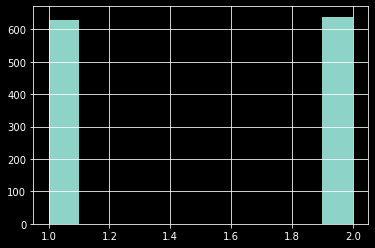

In [17]:
# dataset["new_target"] = dataset["target"].apply(change_target)
dataset["new_target"] = dataset["answer"].astype('int')
dataset["new_target"].hist()

<AxesSubplot:>

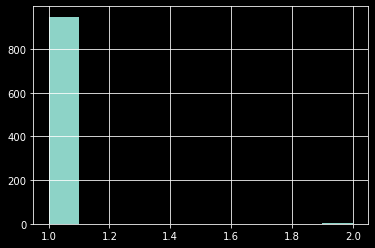

In [22]:
dataset["new_out"] = dataset["out_text"].apply(change_target)
dataset["new_out"].hist()

In [26]:
dataset.groupby(["new_out"]).count()

,sentence,option1,option2,answer,instruction,input,output,context,target,res,res_sentences,out_text,new_target
new_out,,,,,,,,,,,,,
1.0,948,948,948,948,948,948,948,948,948,948,948,948,948
2.0,3,3,3,3,3,3,3,3,3,3,3,3,3


### 8-bit

In [33]:
dataset.shape

(1267, 14)

: 

In [28]:
dataset["new_out"] = dataset["new_out"].fillna(-1)

In [29]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.3654301499605367

In [30]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.19646989368038756

In [31]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.3654301499605367

In [32]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.2921732814574765

### Full

In [37]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.49347116430903154

In [38]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.2870312481392829

In [39]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.49347116430903154

In [40]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.42840616148615157

In [41]:
dataset.to_csv("fiqa_ori.csv")